# Kaggle Titanic by hanyunxuan

* ** Step1:Load and check data**
* **Step2:Filling missing Values**
* **Step3:Feature engineering**
* **Step4:Modelling**

In [1]:
# data analysis 
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Step1:Load and check data 
### 1.1.Load data

In [2]:
train = pd.read_csv('E:\Kaggle\Titanic\\train.csv')
test = pd.read_csv('E:\Kaggle\Titanic\\test.csv')
PassengerId = test.PassengerId

In [3]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.2.Outlier detection(Numerical values)

In [6]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers


Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


## 1.3.Joining train and test set

In [7]:
train_len = len(train)
data_set = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## 1.4.Check for null and missing values

In [8]:
data_set = data_set.fillna(np.nan)

In [9]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          292 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


## Step2:Filling missing Values

### 2.1.Fare
Only one data is missing,so i dicide fill it with median of fare

In [10]:
median_fare = data_set.Fare.median()
data_set.Fare = data_set.Fare.fillna(median_fare)

### 2.2.Embarked
Only one datas are missing,so i dicide fill it with median of fare

In [11]:
Counter(data_set["Embarked"])

Counter({'S': 904, 'C': 270, 'Q': 123, nan: 2})

In [12]:
data_set.Embarked = data_set.Embarked.fillna('S')

## Step3:Feature engineering
### 3.1.Name
Pick up title from name and cluster

In [13]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data_set["Name"]]
data_set["Title"] = pd.Series(dataset_title)
data_set.drop(['Name'], axis=1, inplace=True)

In [14]:
data_set["Title"] = data_set["Title"].replace(
    ['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data_set['Title'] = data_set['Title'].replace('Mlle', 'Miss')
data_set['Title'] = data_set['Title'].replace('Ms', 'Miss')
data_set['Title'] = data_set['Title'].replace('Mme', 'Mrs')

In [15]:
data_set["Title"] = data_set["Title"].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4})

### 3.2.Parch and Sibsp
Creat a new feature named Fsize which add parch and sibsp

In [16]:
data_set["Fsize"] = data_set["SibSp"] + data_set["Parch"] + 1
data_set.drop(['SibSp'], axis=1, inplace=True)
data_set.drop(['Parch'], axis=1, inplace=True)
data_set['Single'] = data_set['Fsize'].map(lambda s: 1 if s == 1 else 0)
data_set['SmallF'] = data_set['Fsize'].map(lambda s: 1 if  s == 2  else 0)
data_set['MedF'] = data_set['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
data_set['LargeF'] = data_set['Fsize'].map(lambda s: 1 if s >= 5 else 0)

### 3.3.Ticket
Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

In [17]:
Ticket = []
for i in list(data_set.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])  # Take prefix
    else:
        Ticket.append("X")
data_set["Ticket"] = Ticket

### 3.4.Cabin

In [18]:
data_set["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in data_set['Cabin']])

In [19]:
Counter(data_set["Cabin"])

Counter({'A': 22,
         'B': 65,
         'C': 91,
         'D': 46,
         'E': 41,
         'F': 21,
         'G': 5,
         'T': 1,
         'X': 1007})

In [20]:
data_set["Cabin"] = data_set["Cabin"].map({"X": 0, "C": 1, "B": 2, "D": 3, "E": 4, "A": 5, "F": 6, "G": 7, "T": 8})

### 3.5.Embarked

In [21]:
Counter(data_set["Embarked"])

Counter({'C': 270, 'Q': 123, 'S': 906})

In [22]:
data_set["Embarked"] = data_set["Embarked"].map({"S": 0, "C": 1, "Q": 2})

### 3.6.PassengerId

In [23]:
data_set.drop(['PassengerId'], axis=1, inplace=True)

### 3.7.Sex

In [24]:
data_set["Sex"] = data_set["Sex"].map({"male": 0, "female": 1})

### 3.8.Age

In [25]:
data_set.head()

,Age,Cabin,Embarked,Fare,Pclass,Sex,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,0,0,7.2500,3,0,0.0,A5,0,2,0,1,0,0
1,38.0,1,1,71.2833,1,1,1.0,PC,2,2,0,1,0,0
2,26.0,0,0,7.9250,3,1,1.0,STONO2,1,1,1,0,0,0
3,35.0,1,0,53.1000,1,1,1.0,X,2,2,0,1,0,0
4,35.0,0,0,8.0500,3,0,0.0,X,0,1,1,0,0,0


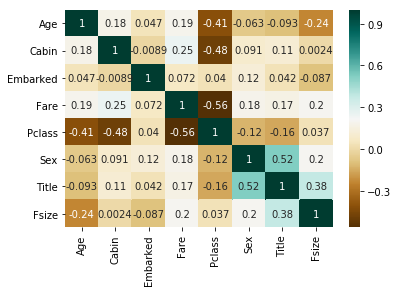

In [26]:
g = sns.heatmap(data_set[["Age","Cabin","Embarked","Fare","Pclass","Sex","Title","Fsize"]].corr(),cmap="BrBG",annot=True)

In [27]:
index_NaN_age = list(data_set["Age"][data_set["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = data_set["Age"].median()
    age_pred = data_set["Age"][(
                (data_set['Cabin'] == data_set.iloc[i]["Cabin"]) & (data_set['Fare'] == data_set.iloc[i]["Fare"]) & (
                    data_set['Embarked'] == data_set.iloc[i]["Embarked"]))].median()
    if not np.isnan(age_pred):
        data_set['Age'].iloc[i] = age_pred
    else:
        data_set['Age'].iloc[i] = age_med

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
data_set = pd.get_dummies(data_set, columns=["Title"])
data_set = pd.get_dummies(data_set, columns=["Ticket"], prefix="T")
data_set = pd.get_dummies(data_set, columns=["Pclass"])
data_set = pd.get_dummies(data_set, columns=["Sex"])
data_set = pd.get_dummies(data_set, columns=["Cabin"])
data_set = pd.get_dummies(data_set, columns=["Embarked"])

In [29]:
data_set.head()

,Age,Fare,Survived,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,...,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7,Cabin_8,Embarked_0,Embarked_1,Embarked_2
0,22.0,7.2500,0.0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38.0,71.2833,1.0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,26.0,7.9250,1.0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,35.0,53.1000,1.0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,35.0,8.0500,0.0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Step4:model

In [30]:
train_data = data_set[:train_len]
X_test = data_set[train_len:]
X_test = X_test.drop(labels=["Survived"], axis=1)

train_data["Survived"] = train_data["Survived"].astype(int)
Y_train = train_data["Survived"]
X_train = train_data.drop(labels=["Survived"], axis=1)

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_LR = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

83.540000000000006

In [32]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_SVM = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.430000000000007

In [33]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_KNN = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.239999999999995

In [34]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_GNB = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

45.740000000000002

In [35]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_Per = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


73.890000000000001

In [36]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_LSVC = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

84.219999999999999

In [37]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred_SGD = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


69.810000000000002

In [38]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_DT = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

98.859999999999999

In [39]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RF = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.859999999999999

In [40]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.86
8,Decision Tree,98.86
1,KNN,85.24
7,Linear SVC,84.22
2,Logistic Regression,83.54
0,Support Vector Machines,83.43
5,Perceptron,73.89
6,Stochastic Gradient Decent,69.81
4,Naive Bayes,45.74
